In [1]:
import os
import datetime
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, save_summary_and_results

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


folder_path = '/home/rl_sim/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_TRANSF_FTP_NotNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

#X_data = np.dstack((X_data[:, :, 2], X_data[:, :, 0], X_data[:, :, 6], X_data[:, :, 7],X_data[:, :, 8]))    # TO DECOMMENT!
print("\nSelectedInputs: ", X_data.shape)
print("SelectedInputs: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)
print("X_train shape:", X_train.shape)

IN_SHAPE = (WS_B, 5) #X_data[0].shape
TYPEm = "ANN_G"

2024-09-08 15:44:49.932191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 15:44:49.957391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 15:44:50.364638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-08 15:44:50.698459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)

SelectedInputs:  (1465, 800, 9)
SelectedInputs:  (800, 9)

TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 9)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 9)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 9)    ||  Dimensions of y_val:   (293,)
X_train shape: (879, 800, 9)


In [2]:
X_train_ = np.dstack([X_train[:, :, i] for i in range(9)])
X_val_ = np.dstack([X_val[:, :, i] for i in range(9)])
X_test_ = np.dstack([X_test[:, :, i] for i in range(9)])

print("X_train shape:", X_train_.shape)


X_train shape: (879, 800, 9)


# ALL 9 DATA IN SINGLE BRANCH

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 800, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │     1,843,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,911,553 (7.29 MB)

 Trainable params: 1,910,529 (7.29 MB)

 Non-trainable params: 1,024 (4.00 KB)

X_train shape: (879, 800, 9)
Epoch 1/40


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7432 - loss: 0.5460 - val_accuracy: 0.7167 - val_loss: 1.2574
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8358 - loss: 0.3625 - val_accuracy: 0.7372 - val_loss: 0.5606
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8866 - loss: 0.3036 - val_accuracy: 0.7782 - val_loss: 0.4844
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8852 - loss: 0.2825 - val_accuracy: 0.7406 - val_loss: 0.8612
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8842 - loss: 0.2970 - val_accuracy: 0.8601 - val_loss: 0.3208
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9048 - loss: 0.2596 - val_accuracy: 0.8976 - val_loss: 0.2579
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8916 - loss: 0.2945 - val_accuracy: 0.7679 - val_loss: 0.6198
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9112 - loss: 0.2154 - val_accuracy: 0.8942 - val_loss: 0.2672
Ep

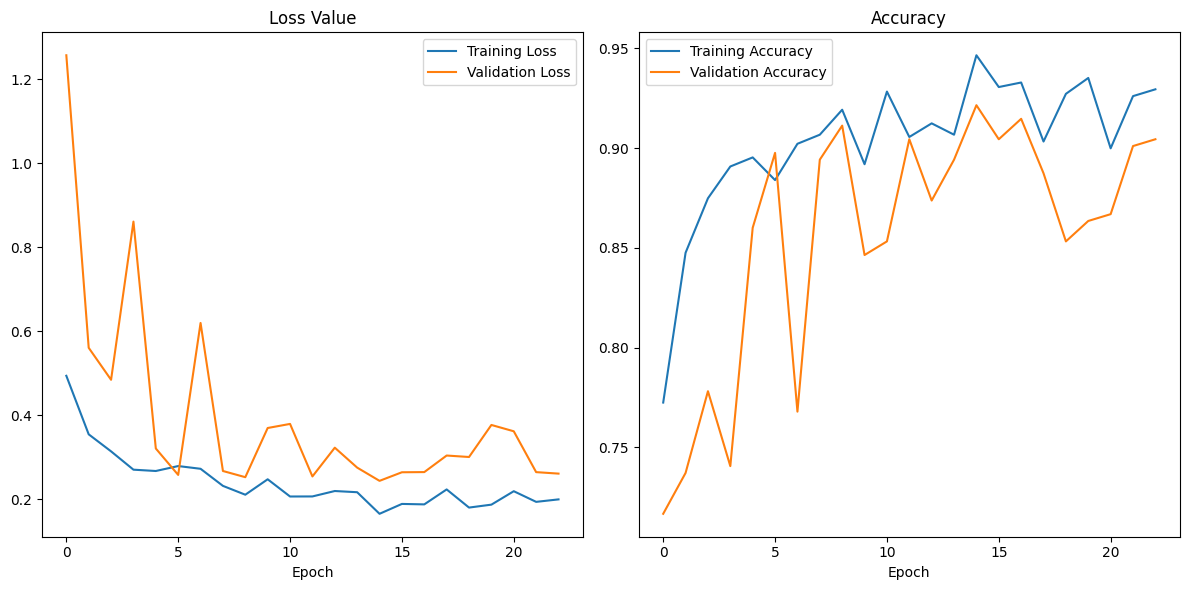

Train loss: 0.19959306716918945
Test val_loss: 0.2609776258468628
Train accuracy: 0.9294652938842773
Test Accuracy Score: 0.8839590443686007
F1 Score: 0.8866666666666667
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       137
         1.0       0.92      0.85      0.89       156

    accuracy                           0.88       293
   macro avg       0.88      0.89      0.88       293
weighted avg       0.89      0.88      0.88       293



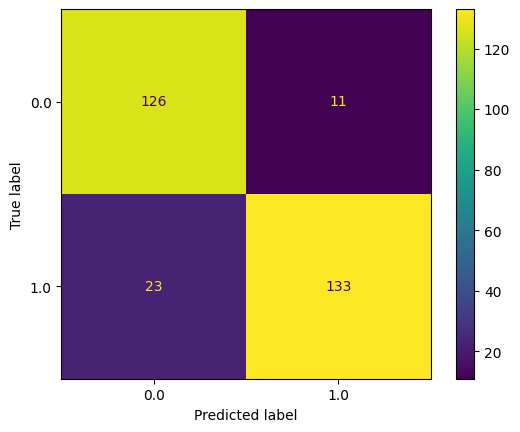

In [25]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Build the feed-forward ANN
def build_ff_ann():
    inputs = Input(shape=(800, 9))  # Input shape matches your dataset (800 features and 9 slices)
    x = Flatten()(inputs)  # Flatten the 3D input to 1D for the dense layers
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_ff_ann()
model.summary()

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are already loaded
X_train_ = np.dstack([X_train[:, :, i] for i in range(9)])  # Combine the 9 slices
X_val_ = np.dstack([X_val[:, :, i] for i in range(9)])      # Combine for validation
X_test_ = np.dstack([X_test[:, :, i] for i in range(9)])    # Combine for testing

print("X_train shape:", X_train_.shape)

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(X_train_, y_train, epochs=40, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute F1 score and accuracy
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Plotting loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss Value
axs[0].plot(history.history["loss"], label="Training Loss")
axs[0].plot(history.history["val_loss"], label="Validation Loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="Training Accuracy")
axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Test Accuracy Score:", accuracy)
print("F1 Score:", f1)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
plt.show()


# SELECTED 5 INPUT SINGLE BRANCH SIMPLE

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,353 (4.17 MB)

 Trainable params: 1,091,329 (4.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/40


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7014 - loss: 0.6011 - val_accuracy: 0.6758 - val_loss: 0.9282
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8318 - loss: 0.3652 - val_accuracy: 0.7235 - val_loss: 0.7317
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8816 - loss: 0.3330 - val_accuracy: 0.7577 - val_loss: 0.5706
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8699 - loss: 0.3370 - val_accuracy: 0.7372 - val_loss: 0.5068
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9026 - loss: 0.2759 - val_accuracy: 0.7850 - val_loss: 0.6167
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8489 - loss: 0.3162 - val_accuracy: 0.6485 - val_loss: 1.1213
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8926 - loss: 0.2673 - val_accuracy: 0.8020 - val_loss: 0.4254
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9087 - loss: 0.2455 - val_accuracy: 0.8703 - val_loss: 0.3034
Ep

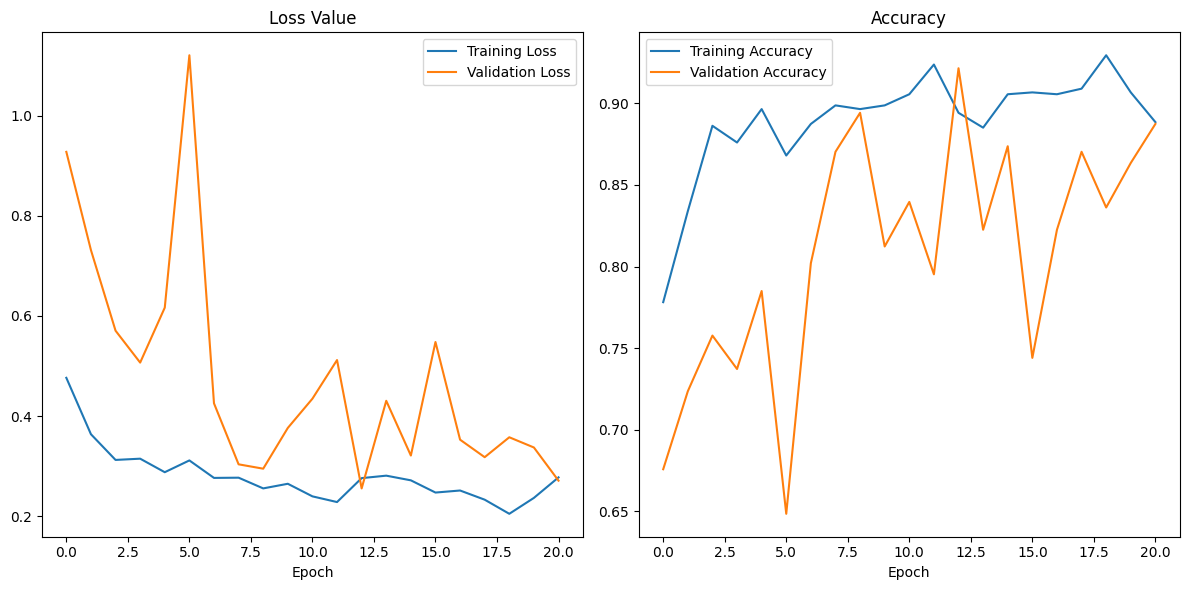

Train loss: 0.27725109457969666
Test val_loss: 0.2707054316997528
Train accuracy: 0.8885096907615662
Test Accuracy Score: 0.8737201365187713
F1 Score: 0.8745762711864407
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       137
         1.0       0.93      0.83      0.87       156

    accuracy                           0.87       293
   macro avg       0.88      0.88      0.87       293
weighted avg       0.88      0.87      0.87       293



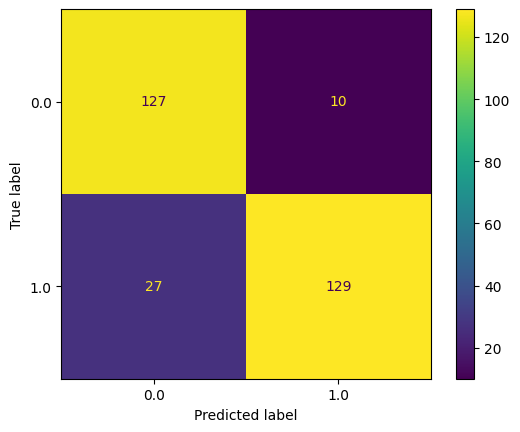

In [16]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Build the feed-forward ANN with Flatten
def build_ff_ann():
    inputs = Input(shape=(800, 5))  # Input shape matches the selected slices
    x = Flatten()(inputs)  # Flatten the 3D input into a 1D vector
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_ff_ann()
model.summary()

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Select specific slices of data using np.dstack
X_data_ = np.dstack((X_data[:, :, 2], X_data[:, :, 0], X_data[:, :, 5], X_data[:, :, 6], X_data[:, :, 8]))

# Split the data into training, validation, and testing sets
TEST_SIZE = 0.4
X_train_, X_temp, y_train, y_temp = train_test_split(X_data_, y_data, test_size=TEST_SIZE, random_state=42)
X_val_, X_test_, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(X_train_, y_train, epochs=40, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute F1 score and accuracy
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Plotting loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss Value
axs[0].plot(history.history["loss"], label="Training Loss")
axs[0].plot(history.history["val_loss"], label="Validation Loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="Training Accuracy")
axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Test Accuracy Score:", accuracy)
print("F1 Score:", f1)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
plt.show()


# COMPLEX-BULKY FF-ANN

2024-09-06 18:16:08.843169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-06 18:16:08.843365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-06 18:16:08.843486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129,665 (4.31 MB)

 Trainable params: 1,128,385 (4.30 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25


I0000 00:00:1725639369.775229  147601 service.cc:145] XLA service 0x7f1ae8012a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725639369.775263  147601 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-06 18:16:09.838138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 18:16:09.990655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.5000 - loss: 0.8174

I0000 00:00:1725639371.833096  147601 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6671 - loss: 0.6497 - val_accuracy: 0.4676 - val_loss: 2.7609
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7726 - loss: 0.4802 - val_accuracy: 0.5631 - val_loss: 1.9798
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.4047 - val_accuracy: 0.5836 - val_loss: 1.3493
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8368 - loss: 0.3567 - val_accuracy: 0.6689 - val_loss: 0.8191
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8129 - loss: 0.3934 - val_accuracy: 0.6724 - val_loss: 0.6881
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.3439 - val_accuracy: 0.7372 - val_loss: 0.5570
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3386 - val_accuracy: 0.7577 - val_loss: 0.5384
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8668 - loss: 0.2960 - val_accuracy: 0.8123 - val_loss: 0.3910
Ep

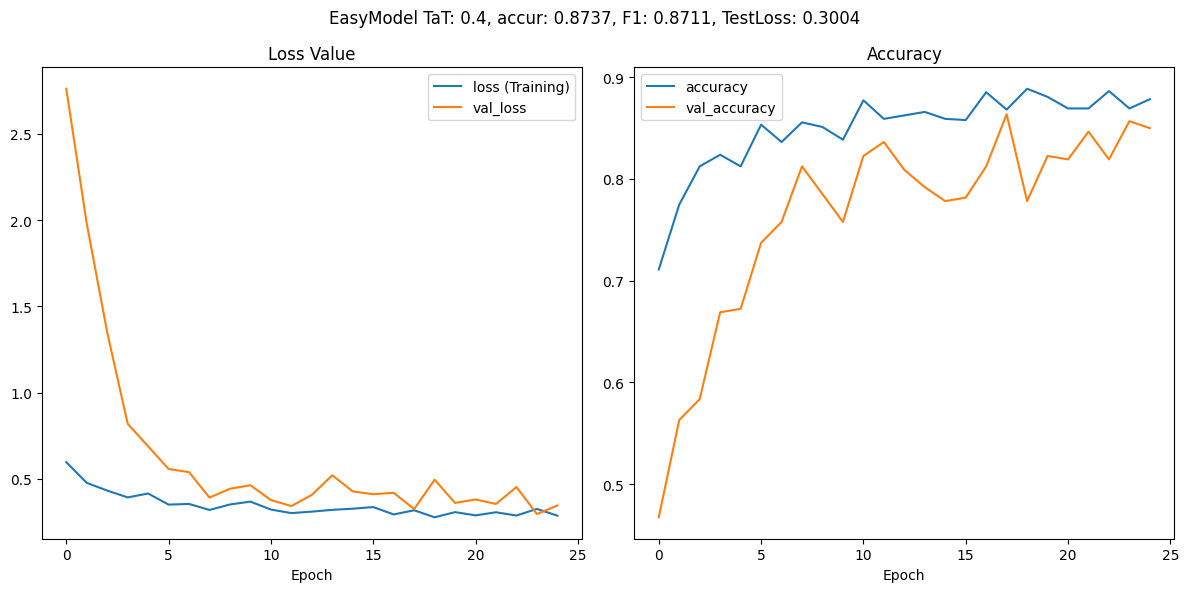

Train loss: 0.28612351417541504
Test val_loss: 0.3449321389198303
Train accuracy: 0.8782707452774048
Accuracy Score: 0.8737201365187713
F1 Score: 0.8710801393728222
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.96      0.88       137
         1.0       0.95      0.80      0.87       156

    accuracy                           0.87       293
   macro avg       0.88      0.88      0.87       293
weighted avg       0.89      0.87      0.87       293



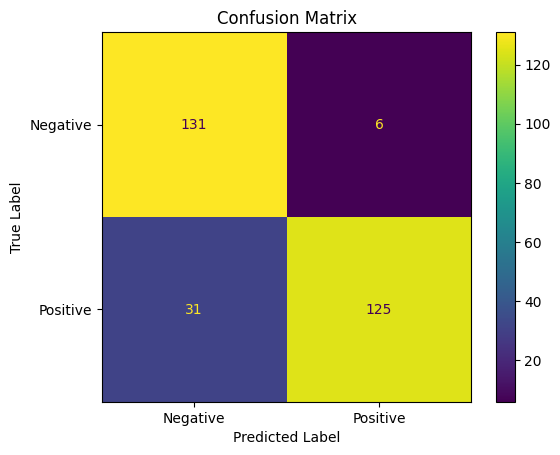

In [2]:

def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [3]:
# model_name = f"FF_{TYPEm}_5LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# BRANCHED ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 800, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4000)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  1,024,256 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │  1,024,256 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    512,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │    512,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_13[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │    256,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     16,448 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 352)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_10[0][0],   │
│                     │                   │            │ dense_12[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 352)       │      1,408 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     22,592 │ batch_normalizat

 Total params: 3,421,857 (13.05 MB)

 Trainable params: 3,420,641 (13.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.6814 - loss: 0.6564 - val_accuracy: 0.6860 - val_loss: 3.0185
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4611 - val_accuracy: 0.6655 - val_loss: 0.8895
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8027 - loss: 0.4149 - val_accuracy: 0.6485 - val_loss: 1.0718
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8342 - loss: 0.3940 - val_accuracy: 0.6997 - val_loss: 1.0055
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3525 - val_accuracy: 0.7543 - val_loss: 0.5696
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.3353 - val_accuracy: 0.7509 - val_loss: 0.5682
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.3519 - val_accuracy: 0.7918 - val_loss: 0.3975
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8720 - loss: 0.3004 - val_accuracy: 0.8259 - val_los

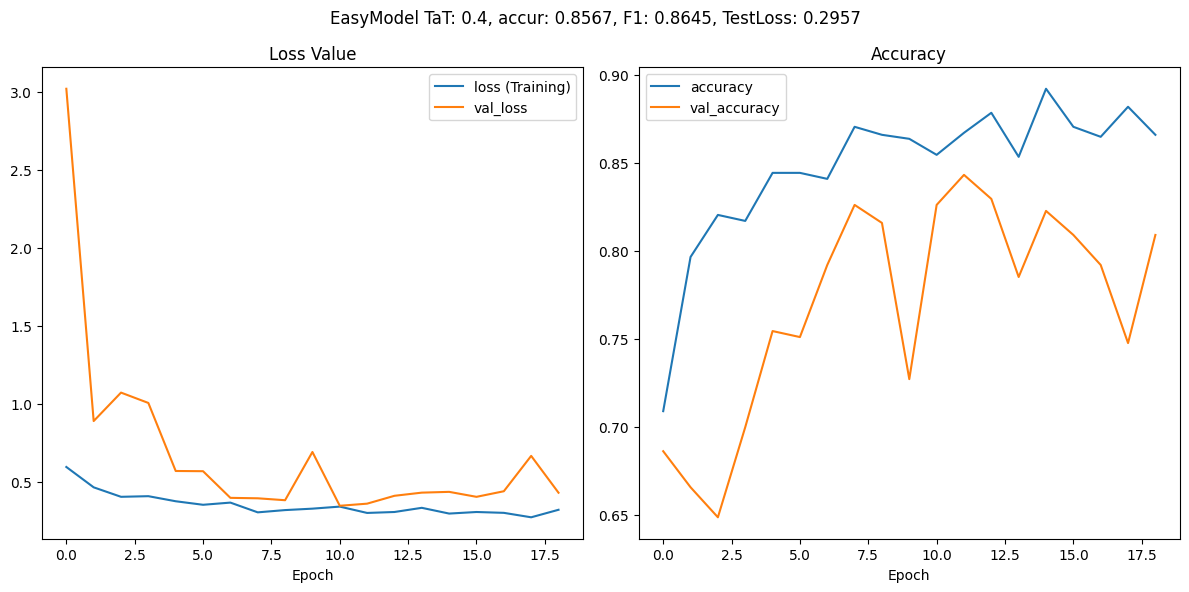

Train loss: 0.3210546374320984
Test val_loss: 0.43028876185417175
Train accuracy: 0.8657565712928772
Accuracy Score: 0.856655290102389
F1 Score: 0.864516129032258
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.85       137
         1.0       0.87      0.86      0.86       156

    accuracy                           0.86       293
   macro avg       0.86      0.86      0.86       293
weighted avg       0.86      0.86      0.86       293



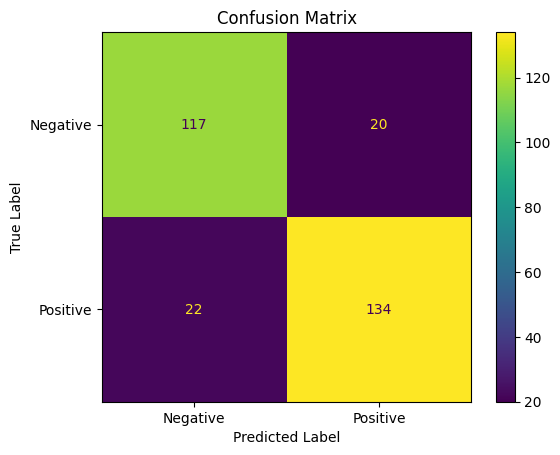

In [4]:
def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Branch 5
    branch5 = Dense(256, kernel_initializer=GlorotUniform())(flatten_layer)
    branch5 = LeakyReLU(alpha=0.1)(branch5)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(64, kernel_initializer=GlorotUniform(), activation='relu')(branch5)


    # Merge branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output, branch5_output])
    merged = BatchNormalization()(merged)
    merged = Dense(64, activation='relu')(merged)
    
    output_layer = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [5]:
# model_name = f"FF_{TYPEm}_BRANCHEDModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# ARTICULATED BRANCH

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 800, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4000)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │  1,024,256 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │    512,128 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │    512,128 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │    256,064 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      2,080 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 288)       │          0 │ dense_18[0][0],   │
│ (Concatenate)       │                   │            │ dense_20[0][0],   │
│                     │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288)       │      1,152 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     36,992 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ dense_30[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,432,897 (9.28 MB)

 Trainable params: 2,431,617 (9.28 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:39 6s/step - accuracy: 0.5000 - loss: 0.7494

I0000 00:00:1725639392.547397  151717 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 8 bytes spill stores, 8 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6059 - loss: 0.6673

I0000 00:00:1725639395.306776  151923 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 8 bytes spill stores, 8 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.6072 - loss: 0.6662 - val_accuracy: 0.4881 - val_loss: 4.3331
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6691 - loss: 0.6223 - val_accuracy: 0.6212 - val_loss: 1.6841
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7923 - loss: 0.4249 - val_accuracy: 0.7031 - val_loss: 1.2848
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8277 - loss: 0.4486 - val_accuracy: 0.6997 - val_loss: 1.4955
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.3904 - val_accuracy: 0.7611 - val_loss: 0.5590
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3246 - val_accuracy: 0.7201 - val_loss: 0.6319
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.3349 - val_accuracy: 0.7338 - val_loss: 0.8472
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - loss: 0.3914 - val_accuracy: 0.7372 - val_loss: 0.6838


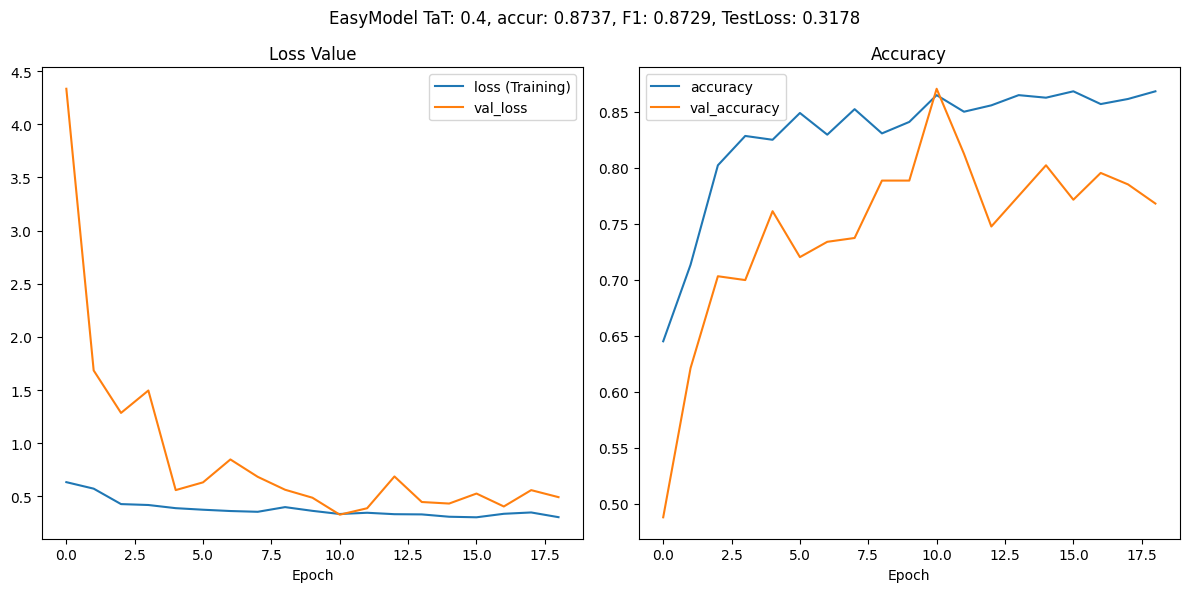

Train loss: 0.30432888865470886
Test val_loss: 0.49256575107574463
Train accuracy: 0.8680318593978882
Accuracy Score: 0.8737201365187713
F1 Score: 0.872852233676976
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.94      0.87       137
         1.0       0.94      0.81      0.87       156

    accuracy                           0.87       293
   macro avg       0.88      0.88      0.87       293
weighted avg       0.88      0.87      0.87       293



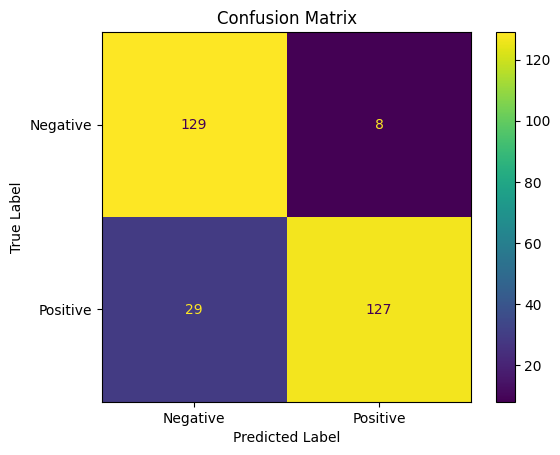

In [6]:
from tensorflow.keras.initializers import GlorotUniform

def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)  # Add a flatten layer
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Merge the first four branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation='relu')(merged)
    
    # Split into three new branches
    branch5 = Dense(64, activation='relu')(merged)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(32, activation='relu')(branch5)
    
    branch6 = Dense(64, activation='relu')(merged)
    branch6 = Dropout(0.2)(branch6)
    branch6_output = Dense(32, activation='relu')(branch6)
    
    branch7 = Dense(64, kernel_initializer=GlorotUniform())(merged)
    branch7 = LeakyReLU(alpha=0.1)(branch7)
    branch7 = Dropout(0.2)(branch7)
    branch7_output = Dense(32, kernel_initializer=GlorotUniform(), activation='relu')(branch7)
    
    # Merge the three branches
    final_merge = concatenate([branch5_output, branch6_output, branch7_output])
    final_merge = BatchNormalization()(final_merge)
    final_merge = Dense(64, activation='relu')(final_merge)
    
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(final_merge)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# To create the model
model = build_ff_ann()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [7]:
# model_name = f"FF_{TYPEm}_ArticulatedModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# M_I, M_B

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 3)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1600)      │          0 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 2400)      │          0 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    409,856 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  1,229,312 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1600)      │          0 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │    410,112 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    409,856 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    131,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     65,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 1024)      │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0],  │
│                     │                   │            │ dense_13[0][0],   │
│                     │                   │            │ dropout_5[0][0] 

 Total params: 2,961,601 (11.30 MB)

 Trainable params: 2,958,785 (11.29 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6917 - loss: 0.6158 - val_accuracy: 0.6655 - val_loss: 2.0887
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8241 - loss: 0.4003 - val_accuracy: 0.6928 - val_loss: 1.1466
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.3992 - val_accuracy: 0.7099 - val_loss: 1.1165
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.3887 - val_accuracy: 0.7747 - val_loss: 0.6177
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8885 - loss: 0.2733 - val_accuracy: 0.7679 - val_loss: 0.5683
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8818 - loss: 0.2954 - val_accuracy: 0.7201 - val_loss: 0.6562
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8877 - loss: 0.2682 - val_accuracy: 0.7952 - val_loss: 0.4764
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8953 - loss: 0.2994 - val_accuracy: 0.8328 - val_loss

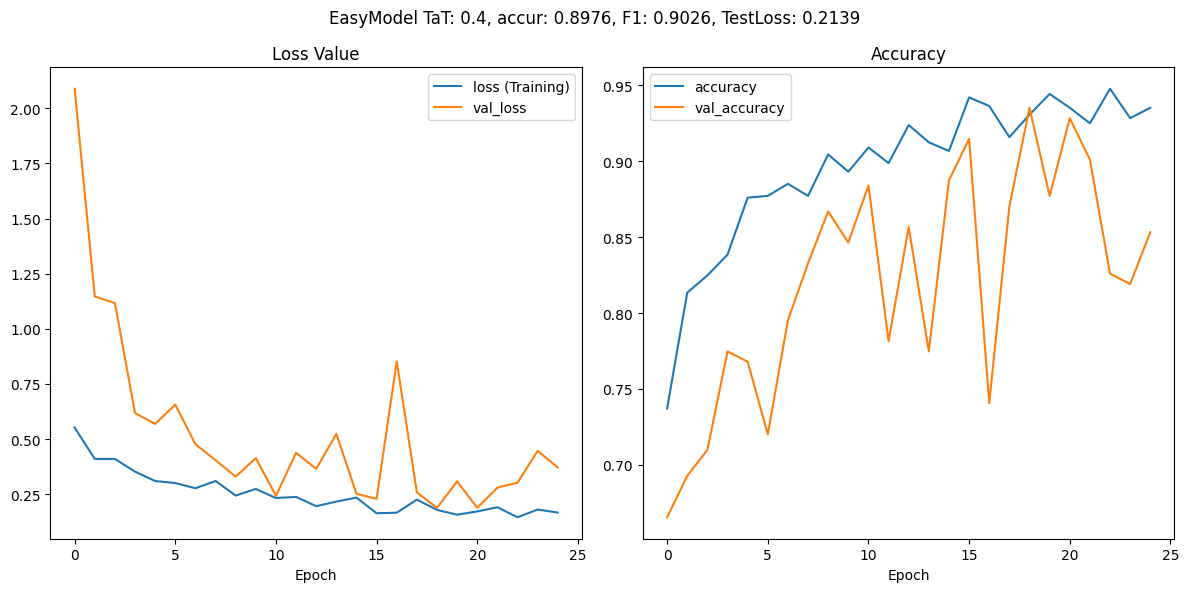

Train loss: 0.16623236238956451
Test val_loss: 0.37089672684669495
Train accuracy: 0.935153603553772
Accuracy Score: 0.8976109215017065
F1 Score: 0.9025974025974026
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       137
         1.0       0.91      0.89      0.90       156

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



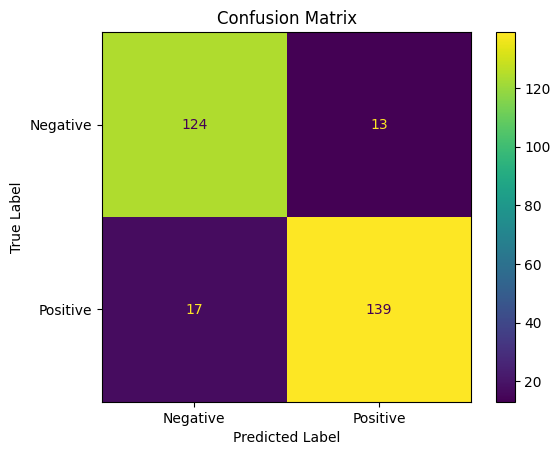

In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, LeakyReLU, Concatenate, ReLU
from tensorflow.keras.models import Model

def build_ff_ann():
    # Input branches
    in1 = Input(shape=(800, 2), name='input1')  # Example of a 2D input that needs flattening
    in2 = Input(shape=(800, 3), name='input2')  # Another 2D input
    in3 = Input(shape=(800,), name='input3')    # 1D input, no flattening needed
    in4 = Input(shape=(800, 2), name='input4')  # 2D input

    # Branch 1 (in1): Flatten + more layers
    b1 = Flatten()(in1)
    b1 = Dense(256, activation='relu')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Dense(512, activation='relu')(b1)
    b1 = Dropout(0.2)(b1)

    # Branch 2 (in3): No flatten needed, small layers (previously Branch 3)
    b2 = Flatten()(in2)
    b2 = Dense(512, activation='relu')(b2)
    b2 = BatchNormalization()(b2)
    b2 = Dense(256, activation='relu')(b2)
    b2 = Dropout(0.1)(b2)

    # Branch 3 (in2): Flatten + fewer layers, larger size (previously Branch 2)
    b3 = Dense(512, activation='relu')(in3)
    b3 = BatchNormalization()(b3)
    b3 = Dense(128, activation='relu')(b3)

    # Branch 4 (in4): Flatten + medium layers
    b4 = Flatten()(in4)
    b4 = Dense(256, activation='relu')(b4)
    b4 = Dense(128, activation='relu')(b4)
    b4 = Dropout(0.1)(b4)

    # Concatenate all branches
    combined = Concatenate(name='concat')([b1, b2, b3, b4])

    # Dense layers after concatenation
    b = Dense(128, activation='relu', name='dense1')(combined)
    b = BatchNormalization()(b)
    b = Dense(32, activation='relu', name='dense2')(b)
    outputs = Dense(1, activation='sigmoid', name='output')(b)

    # Define the model with multiple inputs
    model = Model(inputs=[in1, in2, in3, in4], outputs=outputs)
    return model

# Example usage
model = build_ff_ann()
model.summary()

X_train_ = [np.dstack((X_train[:, :, 0], X_train[:,:, 2])), 
            np.dstack((X_train[:, :, 8], X_train[:,:, 6], X_train[:,:, 5])), 
            X_train[:, :, 2], 
            np.dstack((X_train[:, :, 2], X_train[:,:, 8]))]

X_val_ = [np.dstack((X_val[:, :, 0], X_val[:,:, 2])), 
          np.dstack((X_val[:, :, 8], X_val[:,:, 6], X_val[:,:, 5])), 
          X_val[:, :, 2], 
          np.dstack((X_val[:, :, 2], X_val[:,:, 8]))]

X_test_ = [np.dstack((X_test[:, :, 0], X_test[:,:, 2])), 
           np.dstack((X_test[:, :, 8], X_test[:,:, 6], X_test[:,:, 5])), 
           X_test[:, :, 2], 
           np.dstack((X_test[:, :, 2], X_test[:,:, 8]))]

model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=25, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [ ]:
# import os
# from tensorflow.keras.models import save_model
# TYPEm = "ANN_G"
# model_name = f"FF_{TYPEm}_MultInMulB_v1"
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

## 9B individual

Model: "multi_input_ff_ann"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_3             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_9             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_1    │ (None, 512)       │    410,112 │ input_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_1    │ (None, 512)       │    410,112 │ input_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_bn_1       │ (None, 512)       │      2,048 │ branch_3_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_bn_1       │ (None, 512)       │      2,048 │ branch_9_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_2    │ (None, 512)       │    262,656 │ branch_3_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_4             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_5             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_6             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_7             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_8             │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_2    │ (None, 512)       │    262,656 │ branch_9_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_1_dense_1    │ (None, 256)       │    205,056 │ input_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_2_dense_1    │ (None, 256)       │    205,056 │ input_2[0][0]   

 Total params: 3,651,521 (13.93 MB)

 Trainable params: 3,647,169 (13.91 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.7779 - loss: 0.4449 - val_accuracy: 0.5904 - val_loss: 6.3343
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9118 - loss: 0.2311 - val_accuracy: 0.6962 - val_loss: 1.0260
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9016 - loss: 0.2408 - val_accuracy: 0.7440 - val_loss: 0.8299
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9222 - loss: 0.1638 - val_accuracy: 0.7918 - val_loss: 0.6571
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9424 - loss: 0.1344 - val_accuracy: 0.7918 - val_loss: 0.6806
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9459 - loss: 0.1526 - val_accuracy: 0.8874 - val_loss: 0.2799
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9728 - loss: 0.0917 - val_accuracy: 0.8669 - val_loss: 0.3159
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9529 - loss: 0.1067 - val_accuracy: 0.9113 - val_lo

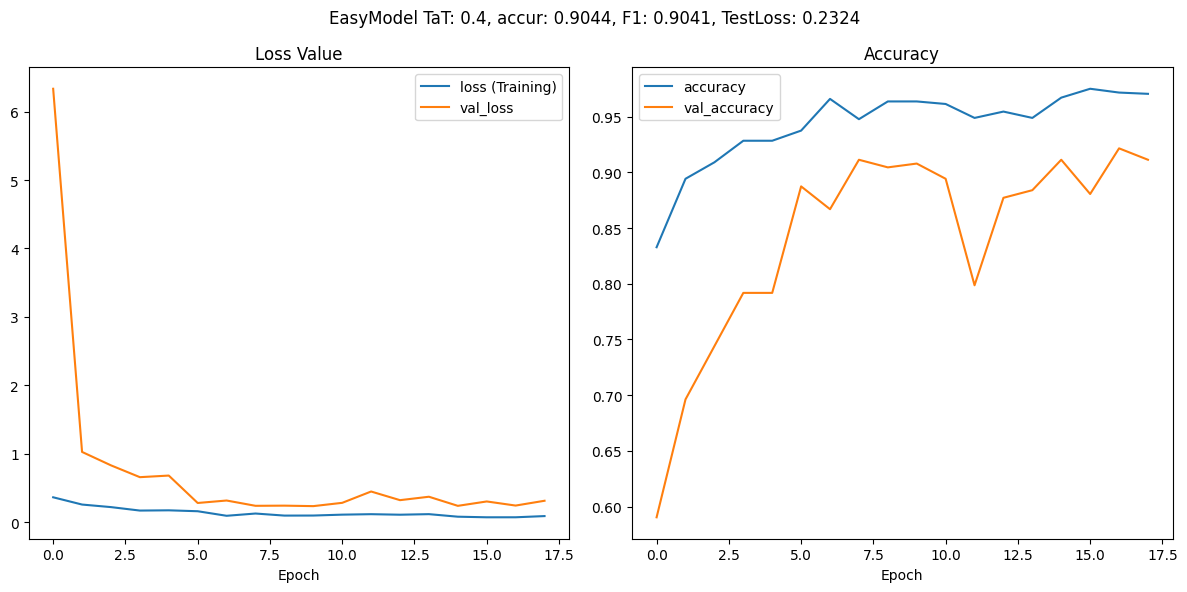

Train loss: 0.08835408836603165
Test val_loss: 0.31230399012565613
Train accuracy: 0.9704209566116333
Accuracy Score: 0.9044368600682594
F1 Score: 0.9041095890410958
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.90       137
         1.0       0.97      0.85      0.90       156

    accuracy                           0.90       293
   macro avg       0.91      0.91      0.90       293
weighted avg       0.91      0.90      0.90       293



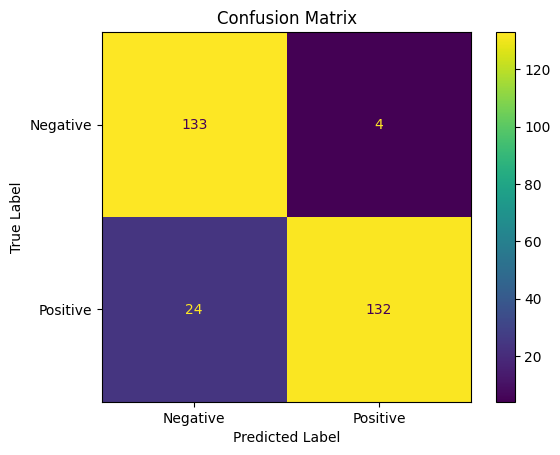

In [9]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, ReLU
from tensorflow.keras.models import Model

def build_ff_ann():
    # Define the input shape
    input_shape = (800,)
    
    # Define each of the 9 branches
    branches = []
    inputs = []

    for i in range(1, 10):
        inp = Input(shape=input_shape, name=f'input_{i}')
        inputs.append(inp)
        
        if i == 3 or i == 9:  # More articulated branches (4 layers)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_1')(inp)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_1')(b)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_3')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_2')(b)
            
        else:  # Basic branches (2 layers)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_1')(inp)          
            b = Dense(128, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
        
        branches.append(b)
    
    # Merge all branches
    merged = Concatenate(name='merged_branches')(branches)
    
    # Additional dense layers after merging
    x = Dense(256, activation='relu', name='merged_dense_1')(merged)
    x = BatchNormalization(name='merged_bn_1')(x)
    x = Dense(32, activation='relu', name='merged_dense_2')(x)
    
    # Final output layer
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    # Define the model with 9 inputs
    model = Model(inputs=inputs, outputs=output, name='multi_input_ff_ann')
    return model

# Example usage
model = build_ff_ann()
model.summary()

X_train_ = [X_train[:, :, i] for i in range(9)]
X_val_ = [X_val[:, :, i] for i in range(9)]
X_test_ = [X_test[:, :, i] for i in range(9)]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=25, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [ ]:
# import os
# from tensorflow.keras.models import save_model
# TYPEm = "ANN_G"
# model_name = f"FF_{TYPEm}_1IN_9B"
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)